<a href="https://colab.research.google.com/github/Aditimajhi/LETS-RENT-IT-/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer , TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

Load the Dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
paths = []
labels=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
        if len(paths) == 2800:
            break
print('Dataset is Loaded')


Dataset is Loaded


In [4]:
len(paths)

2800

In [5]:
paths[:5]

['/content/drive/MyDrive/TESS Toronto emotional speech set data/YAF_sad/YAF_back_sad.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/YAF_sad/YAF_bar_sad.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/YAF_sad/YAF_chair_sad.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/YAF_sad/YAF_check_sad.wav',
 '/content/drive/MyDrive/TESS Toronto emotional speech set data/YAF_sad/YAF_dead_sad.wav']

In [6]:
labels[:5]


['sad', 'sad', 'sad', 'sad', 'sad']

Create a dataframe

In [7]:
df=pd.DataFrame()
df['audio_paths']=paths
df['labels']=labels
df.head()

,audio_paths,labels
0,/content/drive/MyDrive/TESS Toronto emotional ...,sad
1,/content/drive/MyDrive/TESS Toronto emotional ...,sad
2,/content/drive/MyDrive/TESS Toronto emotional ...,sad
3,/content/drive/MyDrive/TESS Toronto emotional ...,sad
4,/content/drive/MyDrive/TESS Toronto emotional ...,sad


In [8]:
df['labels'].value_counts()

,count
labels,
sad,400
neutral,400
fear,400
happy,400
disgust,400
ps,400
angry,400


Exploratory Data Analysis

<Axes: xlabel='labels', ylabel='count'>

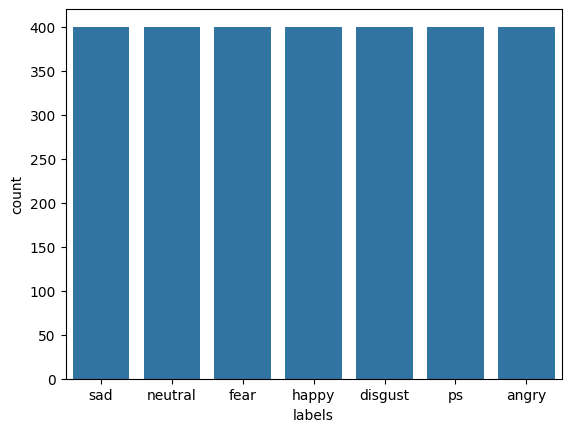

In [9]:
sns.countplot(data = df, x='labels')


functions for waveplot and spectrogram

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(emotion, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()

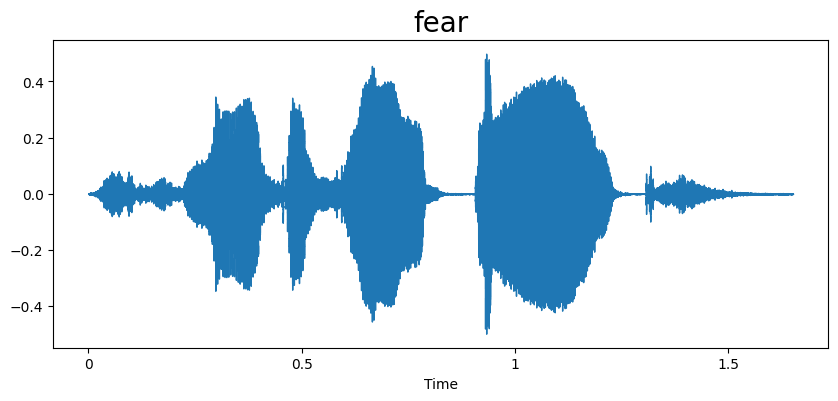

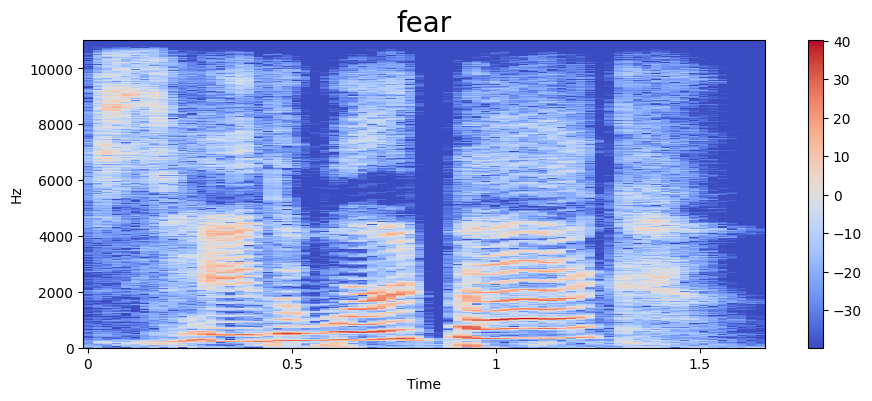

In [11]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


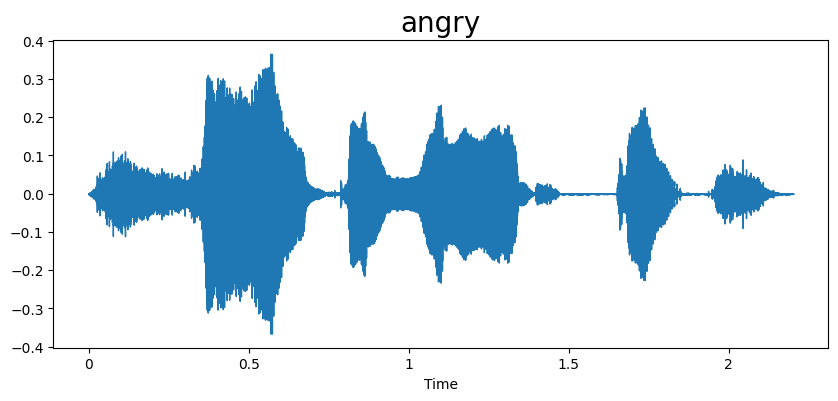

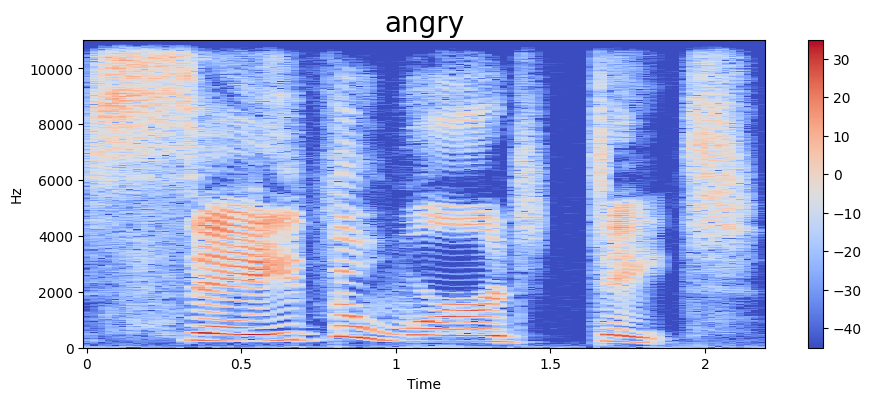

In [12]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


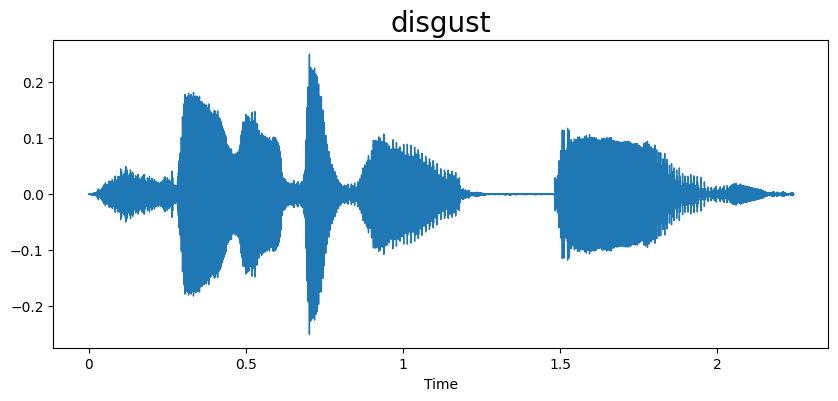

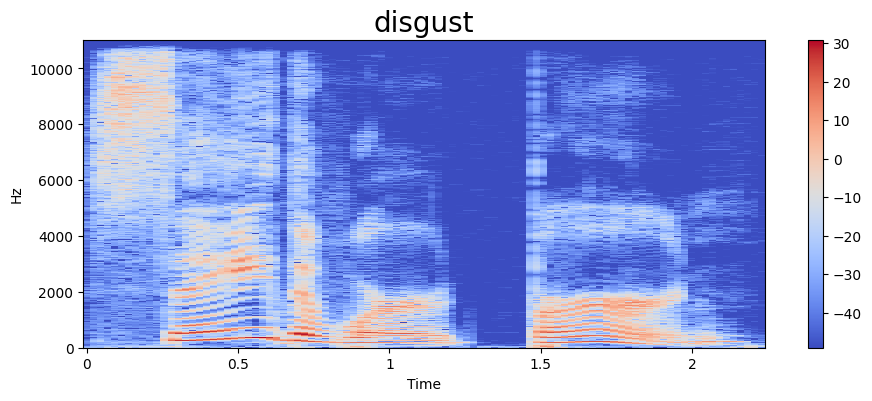

In [13]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

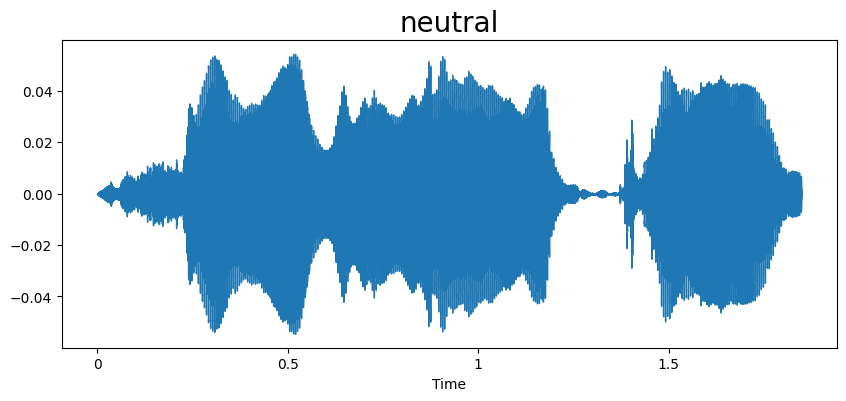

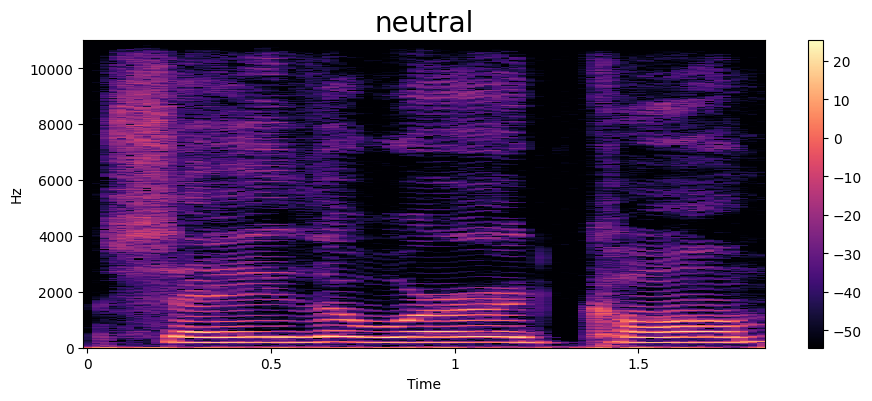

In [14]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

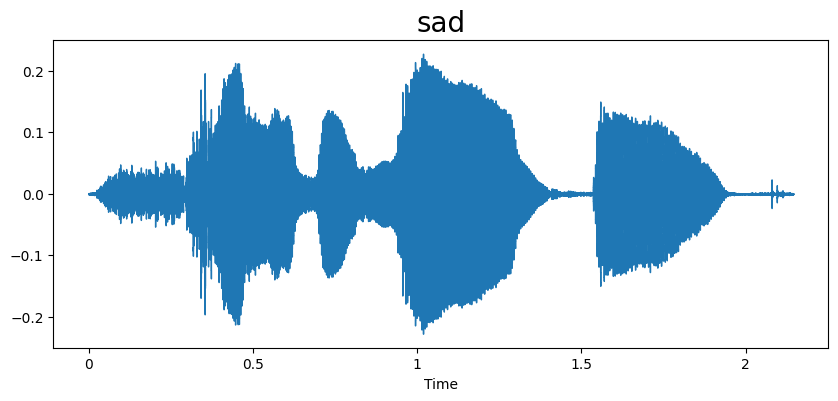

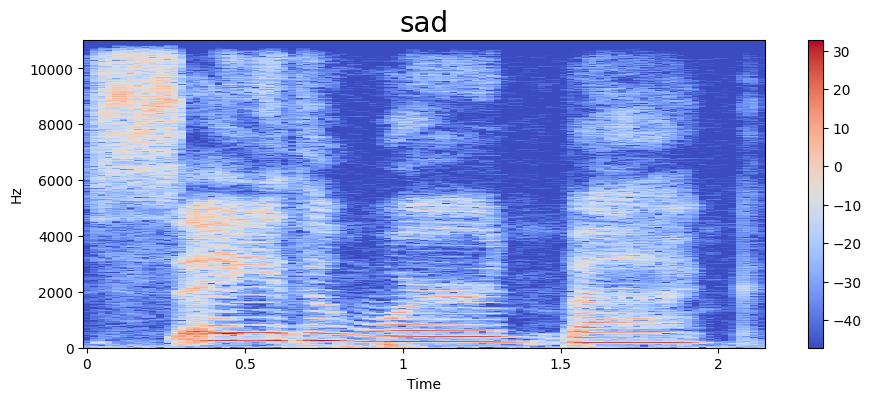

In [15]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

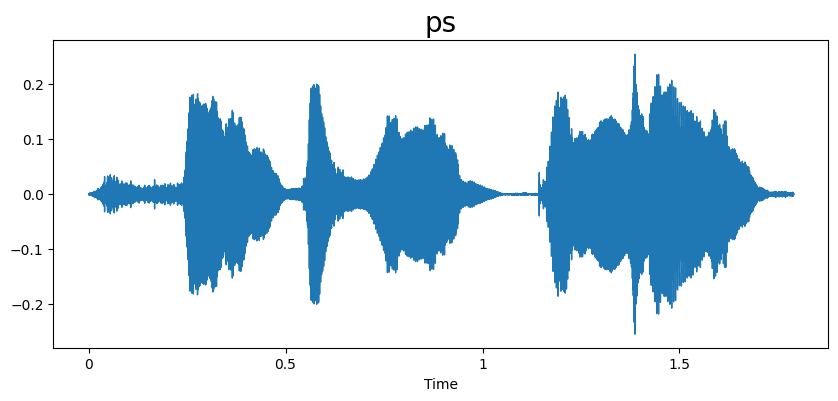

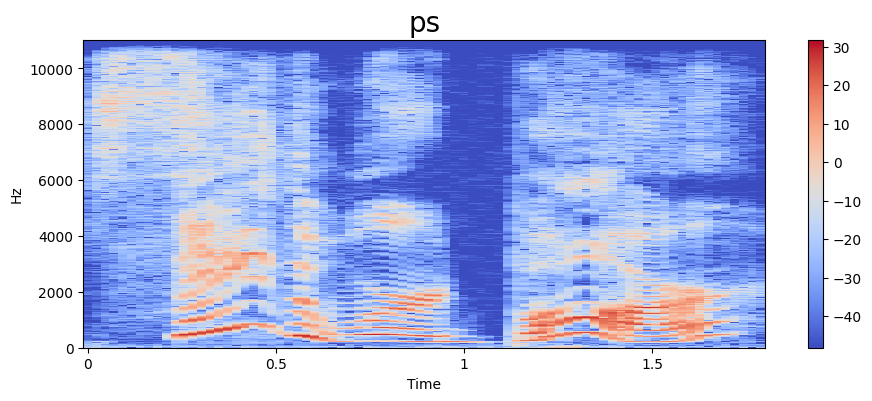

In [16]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

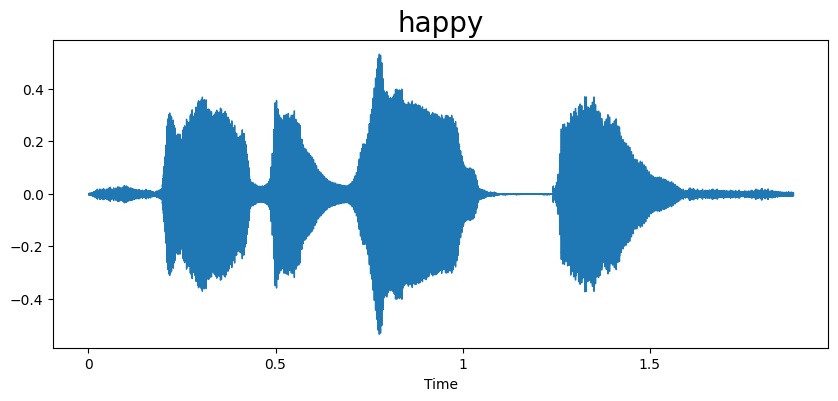

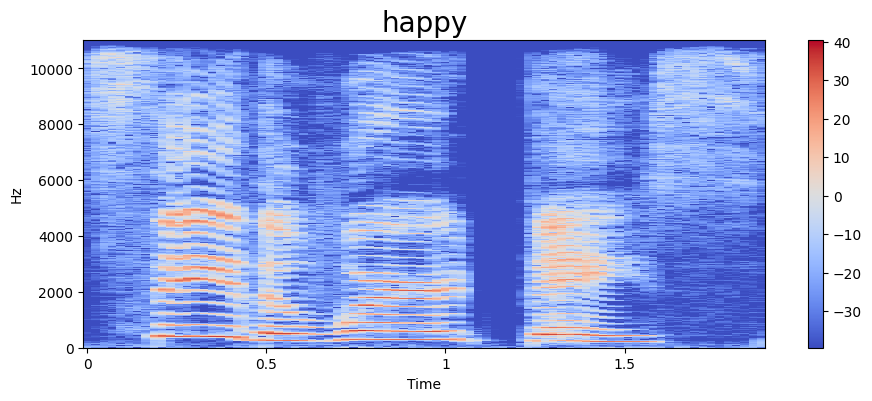

In [17]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

Create Custom Dataset Class

In [18]:
#convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['label'] = df['labels'].map(label_map)
df.head(2)

,audio_paths,labels,label
0,/content/drive/MyDrive/TESS Toronto emotional ...,sad,0
1,/content/drive/MyDrive/TESS Toronto emotional ...,sad,0


In [19]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor,  max_length = 32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['label']

        #load the audio file
        speech, sr  = librosa.load(audio_path, sr=16000)

        #pad or truncate the
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        #preprocessor the audio file
        inputs = self.processor(speech, return_tensors='pt', sampling_rate=16000, padding=True, truncate=True, max_length=self.max_length)
        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

split data for train and test

In [20]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
#initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
#load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [23]:
train_dataset[0]

{'input_values': tensor([ 0.0041, -0.0046, -0.0087,  ...,  0.0006,  0.0006,  0.0006]),
 'labels': tensor(2)}

In [24]:
#create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Set Training Arguments

In [25]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)


In [26]:
#create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids #original labels
    preds = np.argmax(pred.predictions, axis=1) #predicted labels
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [27]:
#initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.536771,1.000000,1.000000,1.000000,1.000000
2,No log,0.197219,0.998214,0.998237,0.998214,0.998214
3,No log,0.146576,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.6367794945126488, metrics={'train_runtime': 1183.9887, 'train_samples_per_second': 5.676, 'train_steps_per_second': 0.355, 'total_flos': 1.2201848064e+17, 'train_loss': 0.6367794945126488, 'epoch': 3.0})

In [28]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.14657631516456604, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 11.44, 'eval_samples_per_second': 48.951, 'eval_steps_per_second': 3.059, 'epoch': 3.0}


test prediction

In [31]:
import random
idx= random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])
print("Predicted Label:", test_dataset[idx]['labels'])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
  outputs = model(input_values)
logits = outputs.logits
predicted_class = logits.argmax(dim=-1).item()
print("predicted label:", inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: tensor(3)
predicted label: happy


In [32]:
idx= random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])
print("Predicted Label:", test_dataset[idx]['labels'])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
  outputs = model(input_values)
logits = outputs.logits
predicted_class = logits.argmax(dim=-1).item()
print("predicted label:", inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: tensor(3)
predicted label: happy
